### Project Overview
- You are required to analyze all of the Active Companies in the S&P 500
- Generate the Volatility of each company
- The market Cap of each company 
- The Expected Return of each company
- How does these companies tie into the Volatility market and what can we determine form this data

In [1]:
import pandas as pd
import numpy as np 
from pandas_datareader import data as web
import seaborn as sns

In [2]:
data = pd.read_csv("resources/companies.csv")

## Data Overview
- There are 505 entries in the data set, but there my be conpanies that my not exist in the set so we will acount for them

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 3 columns):
Symbol    505 non-null object
Name      505 non-null object
Sector    505 non-null object
dtypes: object(3)
memory usage: 12.0+ KB


## Stock Data 
- We will use pandas to get the stock data for each symbol in the list
- Will use data for the last 10 years if exists

In [4]:
failed = []
passed = []
stock_Data = pd.DataFrame()
for x in data["Symbol"]:
    try:
        stock_Data[x] = web.DataReader(x, data_source= "yahoo", start = "2010-1-1")["Adj Close"]
        passed.append(x)
    except (IOError, KeyError):
        msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        failed.append(x)
    

### Companies that failed
- Either does not exist or cannot be fetched by yahoo data reader
- We have 485 companies Passed 
- 20 failed 
- This is a good number to move forward with our analysis

In [5]:
len(failed)

20

In [6]:
len(passed)

485

In [7]:
stock_Data = pd.read_csv("resources/StockData.csv", parse_dates = True, index_col="Date")

### Calculating Volatility
- Calculating the Volatility for each Security

In [8]:
company_Vol= [stock_Data[x].pct_change().std() * np.sqrt(252) for x in stock_Data]

In [9]:
vol_for_period = pd.DataFrame(company_Vol, columns=["Vol"])

In [10]:
vol_for_period.index = passed

### Outlier
- Looks like there is one company disrupting the data set
- Let find that company and see if we should eliminate it
- looks like SCG is the issue- We will visit the web to make a decision on this company
- The Company is SCANA Corporation (SCG) 
- Loks like this company did not last long and the price dropped to 0 within a 1 year perios so we will eliminate it

In [11]:
stock_Data["SCG"].dropna()

Date
2015-07-16    1.018275e+26
2015-07-17    1.018275e+26
2015-07-20    1.018275e+26
2015-07-21    1.018275e+26
2015-07-22    1.018275e+26
                  ...     
2020-05-12    4.500000e-03
2020-05-13    4.500000e-03
2020-05-14    4.500000e-03
2020-05-15    4.500000e-03
2020-05-18    4.500000e-03
Name: SCG, Length: 1219, dtype: float64

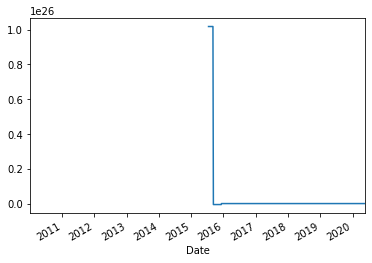

In [12]:
stock_Data["SCG"].plot()

In [13]:
stock_Data['AMZN'].pct_change().std() ** 252 ** 0.5

9.700138257652694e-28

In [14]:
vol_for_period.sort_values("Vol", ascending = True)

,Vol
MON,0.163335
JNJ,0.169479
KO,0.171567
PG,0.172565
PEP,0.174845
...,...
PCG,0.555253
AMD,0.579607
NKTR,0.579943
ARNC,1.677144


In [17]:
data[data['Symbol'] == "ARNC"]

,Symbol,Name,Sector
55,ARNC,Arconic Inc.,Industrials


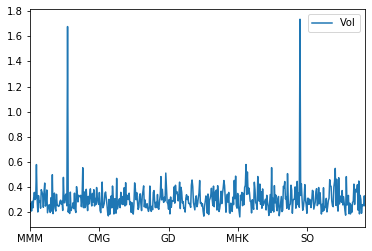

In [18]:
vol_for_period.plot()

In [19]:
vol_for_period.idxmax()

Vol    SCG
dtype: object

### S&P Average Volatility
- From the list below we can that that most of the companies in the s&P have an average volatility around 25%

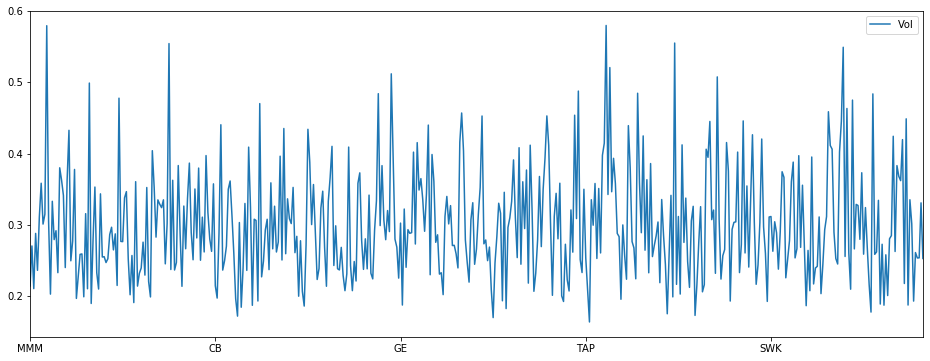

In [20]:
vol_for_period.drop(["SCG", "ARNC"]).plot(figsize = (16,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26953b50>]],
      dtype=object)

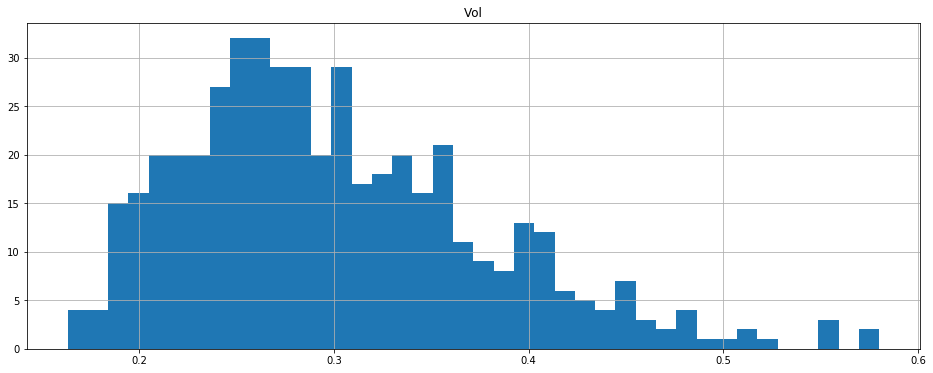

In [21]:
vol_for_period.drop(["SCG", "ARNC"]).hist(figsize = (16,6), bins = 40)

## Combining data
- Add the vol to the data set for the laast 10 years of data

### S&P as a Portfolio 
- What would happen if we had a portfolio that consisted of every company since 2010. What coupanies would have earned us the highest retirns and a 200,000 investment weighted Arbritrarly over the period
- Also what if we optomized this portfolio using a Markowitz Portfolio Oprimization. What portfolio would earn us the highest return
- INvestment data will be 2010-1-04 as a start

## Calculate Normal Returns
- We will first need to eliminate all stocks that have no values on our initial investment dates. 
- Would be difficult to calculate the returns of each stock that would have been in our portfilio
- After droping all the null values we are ready to create our portfolio that will consist of 426 companies since 2010

In [22]:
portfolio_data = stock_Data.dropna(axis=1)

In [23]:
portfolio_data.isnull().sum()

MMM     0
AOS     0
ABT     0
ACN     0
ATVI    0
       ..
XRX     0
XLNX    0
YUM     0
ZBH     0
ZION    0
Length: 426, dtype: int64

In [24]:
port_Tickers = portfolio_data.columns

In [25]:
portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2612 entries, 2010-01-04 to 2020-05-19
Columns: 426 entries, MMM to ZION
dtypes: float64(426)
memory usage: 8.5 MB


In [26]:
for t in portfolio_data.columns:
    portfolio_data[f"{t} normal returns"] = portfolio_data[t]/portfolio_data[t].iloc[0]

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Allocations
- LEts consider how we would weigh each security in the portfolio
- Will randomize the Allocation for each security in the portfolio
- And make sure they will add up to 100% of the portflio

In [27]:
weii = np.random.random(426)
weights = weii/weii.sum()

In [28]:
weights.sum()

1.0

### Calculating Allocations with Weights

In [29]:
port_Allocaitons = pd.DataFrame()
for stock, weight in zip(port_Tickers,weights):
    portfolio_data[f"{stock} allocation"] = portfolio_data[f"{stock} normal returns"] * weight
    port_Allocaitons[f"{stock} allocation"] = portfolio_data[f"{stock} normal returns"] * weight
    

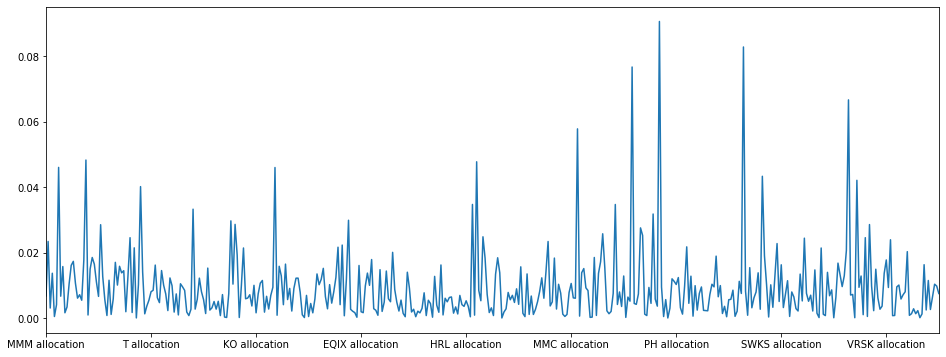

In [30]:
port_Allocaitons.loc["2020-5-19"].plot(figsize = (16,6))

### Leading Companies over a 10 year period 
- Top 20 companies are below in relative to alocations
- Netflix would have had the highest allocaton over a 10 year span 
- Agai nkeep in mind that this is arbritrary values of weights 
- Below we will take a look at 2000 different portfolios weighed randomly

In [31]:
port_Allocaitons.loc["2020-5-19"].sort_values(ascending = False).head(20)

NVDA allocation    0.090543
REGN allocation    0.082754
NFLX allocation    0.076640
TDG allocation     0.066604
MA allocation      0.057755
ALGN allocation    0.048234
IDXX allocation    0.047704
ADBE allocation    0.045988
STZ allocation     0.045951
SPGI allocation    0.043280
ULTA allocation    0.042045
AAPL allocation    0.040123
HUM allocation     0.034680
MCO allocation     0.034665
AVGO allocation    0.033231
NOC allocation     0.031757
EA allocation      0.029848
CMG allocation     0.029661
CHD allocation     0.028589
URI allocation     0.028536
Name: 2020-05-19 00:00:00, dtype: float64

### Calculating Position Value 
- We will invest in the portfolio with a position of 200K

In [32]:
position = pd.DataFrame()
for x in port_Tickers:
    portfolio_data[f"{x} pos for stock"] = portfolio_data[f"{x} allocation"] * 200000
    position[f"{x} positon"] = portfolio_data[f"{x} allocation"] * 200000

In [33]:
len(position)

2612

#### Calculating total Position 
- Lets see the daily Total positon we hold for the period

In [34]:
portfolio_data["total positon"] = position.sum(axis = 1)

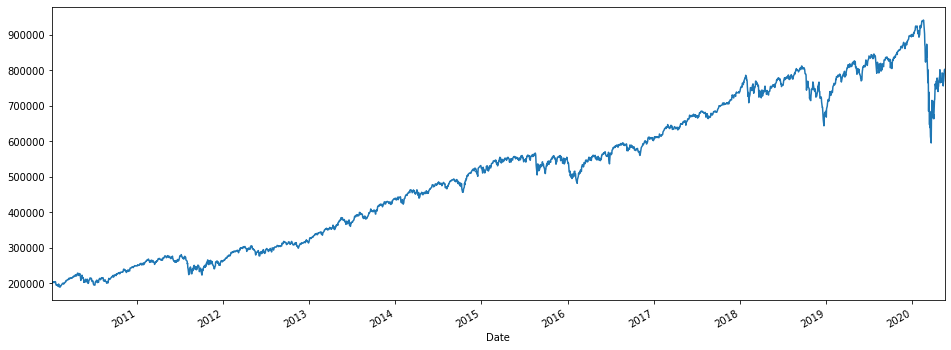

In [35]:
portfolio_data["total positon"].plot(figsize = (16,6))

### Highest Portfolio Position 
- would Have been on first day below 

In [36]:
portfolio_data["total positon"].sort_values(ascending = False)

Date
2020-02-19    941499.345755
2020-02-14    940042.415856
2020-02-20    939975.693398
2020-02-13    937720.910893
2020-02-18    937039.335309
                  ...      
2010-02-09    190920.961805
2010-02-10    190512.666740
2010-02-05    189757.459323
2010-02-04    189344.740377
2010-02-08    188570.949018
Name: total positon, Length: 2612, dtype: float64

### Calculating Daily Portfolio Returns
- We see our portfolio Volatility below
- Vol increase in 2010, late 2011, late 2015,early 2018, 2019 and recent 2020(COVID 19 epedemic)
- for from a educated guess since all companies in this portfolio makes up the S&P the overall/average vol should be close to that of the entire index. We will analyze this later

In [37]:
portfolio_data["daily returns"] = portfolio_data["total positon"].pct_change()

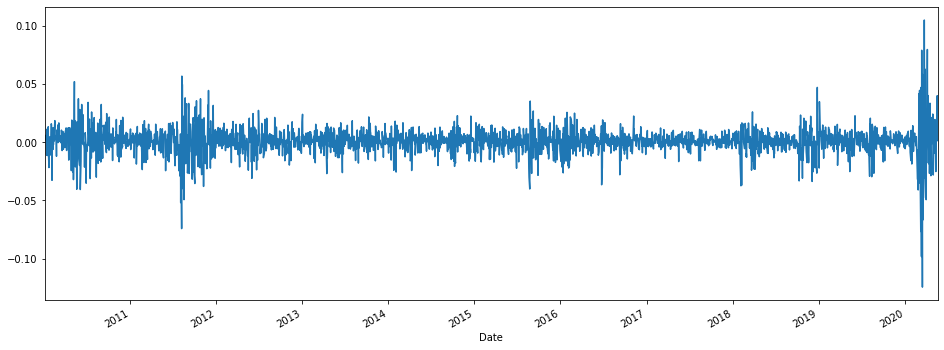

In [38]:
portfolio_data["daily returns"].plot(figsize = (16,6))

## Sharp Ratio
- Since we have the daily returns and the for the Portfilio we can calculate the Sharp Ratio for the portfilio

In [39]:
volatility = portfolio_data["daily returns"].std()

In [40]:
volatility

0.011571221217655058

In [41]:
mean_daily_return = portfolio_data["daily returns"].mean()

In [42]:
mean_daily_return

0.0005993605676253051

In [43]:
sharp = (mean_daily_return/volatility) * np.sqrt(252)

### Sharp Results
- We get at pretty low sharp ratio for this portfolio 
- This is the outcome of having some really volatilie companies and some not 
- Keep in mind this is again using arbritrary Weights 
- We will use markowitz portfolio optimiztion on this portfolio to see what is the max sharp we could get from this portfolio

In [44]:
sharp

0.8222601458049525

### Random Allocation of weights
- We will assign 2000 portfolios with random weights to try to get the max sharp

In [45]:
port_Tickers

Index(['MMM', 'AOS', 'ABT', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AAP', 'AMD', 'AES',
       ...
       'WHR', 'WMB', 'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'YUM', 'ZBH',
       'ZION'],
      dtype='object', length=426)

In [46]:
port_daily_returns = stock_Data.dropna(axis = 1).pct_change()

In [47]:
number_of_ports = 2000
all_weights = np.zeros((number_of_ports, len(port_Tickers)))
all_vol = np.zeros(number_of_ports)
all_returns = np.zeros(number_of_ports)
all_sharps = np.zeros(number_of_ports)

for ind in range(number_of_ports):
    weights = np.random.random(len(port_Tickers))
    weights = weights/weights.sum()
    all_weights[ind,:] = weights
    
    all_returns[ind] = np.sum(port_daily_returns.mean() *weights) * 252 
    all_vol[ind] = np.sqrt(np.dot(weights.T, np.dot(port_daily_returns.cov() * 252, weights)))
    all_sharps[ind] = all_returns[ind]/all_vol[ind]

### Capturing Metrics
- will look at the Max Sharp
- Lowest Vol
- Highest Return

In [50]:
max_sharp = all_sharps.argmax()

In [51]:
max_sharp

213

In [52]:
max_returns = all_returns.argmax()

In [53]:
max_returns

213

In [54]:
lowest_vol =all_vol.argmin()

In [55]:
lowest_vol

834

### Plotting the All portfolios

In [56]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Sharp Ratio of 2000 rendomized Portfolios \n Every company in S&P')

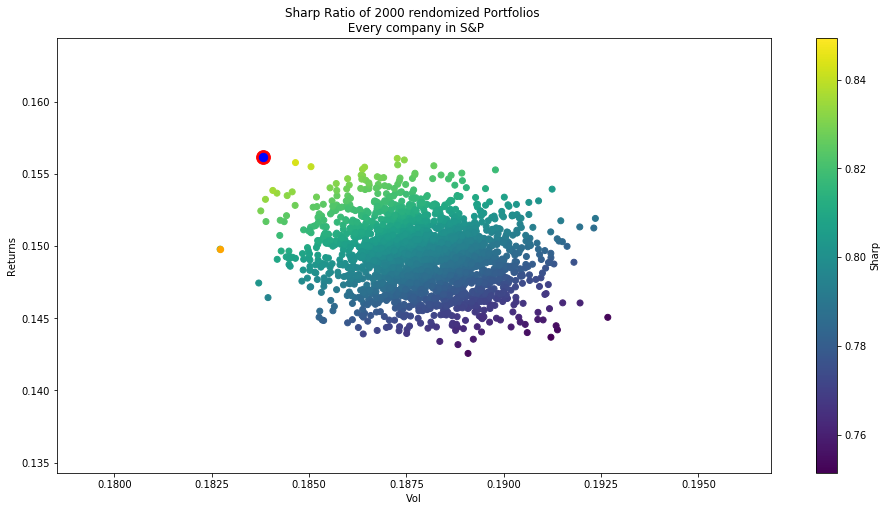

In [93]:
plt.figure(figsize= (16,8))
plt.scatter(all_vol, all_returns, c = all_sharps)
plt.colorbar(label = "Sharp")
plt.scatter(all_vol[max_sharp], all_returns[max_sharp], c = "r", s = 190, label = "Max Sharp")
plt.scatter(all_vol[lowest_vol], all_returns[lowest_vol], c = "orange", s = 40, label  = "Lowest Vol")
plt.scatter(all_vol[max_returns], all_returns[max_returns], c = "b", s = 70, label = "Max Returns")
plt.xlabel("Vol")
plt.ylabel("Returns")
plt.title("Sharp Ratio of 2000 rendomized Portfolios \n Every company in S&P")

### Saving the Data 
- At the data to a DF to csv for future use

In [75]:
random_Df = pd.DataFrame(all_sharps, columns=["Sharps"])

In [77]:
random_Df["all Vols"] = all_vol

In [79]:
random_Df["all_returns"] = all_returns

In [83]:
weights_df = pd.DataFrame(all_weights)

In [85]:
weights_df.columns = port_Tickers

In [87]:
random_allocation_df = pd.concat([random_Df, weights_df], axis=1)

In [89]:
random_allocation_df.to_csv("resources/random_Allocations_DF.csv")

In [90]:
weights_df.to_csv("resources/just_weights.csv")

In [92]:
random_allocation_df[random_allocation_df["Sharps"] == all_sharps.max()]

,Sharps,all Vols,all_returns,MMM,AOS,ABT,ACN,ATVI,AYI,ADBE,...,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,YUM,ZBH,ZION
213,0.849394,0.183828,0.156142,0.004285,0.00313,0.002169,0.002197,0.003488,0.002639,0.003143,...,0.003783,0.003605,0.003951,0.000888,0.002099,0.001061,0.004136,0.000574,0.000576,0.000315


In [96]:
random_allocation_df[random_allocation_df["all_returns"] == all_returns.max()]

,Sharps,all Vols,all_returns,MMM,AOS,ABT,ACN,ATVI,AYI,ADBE,...,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,YUM,ZBH,ZION
213,0.849394,0.183828,0.156142,0.004285,0.00313,0.002169,0.002197,0.003488,0.002639,0.003143,...,0.003783,0.003605,0.003951,0.000888,0.002099,0.001061,0.004136,0.000574,0.000576,0.000315


In [97]:
random_allocation_df[random_allocation_df["all Vols"] == all_vol.min()]

,Sharps,all Vols,all_returns,MMM,AOS,ABT,ACN,ATVI,AYI,ADBE,...,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,YUM,ZBH,ZION
834,0.819759,0.182714,0.149782,0.002405,0.00147,0.0008,0.001875,0.002108,0.001634,0.001536,...,0.001359,0.000539,0.000552,0.000435,0.001473,0.003409,0.001249,0.000123,0.003292,0.001218


In [98]:
weights_df

,MMM,AOS,ABT,ACN,ATVI,AYI,ADBE,AAP,AMD,AES,...,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,YUM,ZBH,ZION
0,0.003477,0.001425,2.868633e-07,0.001667,0.001057,0.003193,0.003028,0.000668,0.004497,0.001018,...,0.000345,0.003904,0.004026,0.000205,0.000783,0.000585,0.003815,0.001741,0.002437,0.004652
1,0.003414,0.004202,4.261506e-03,0.004137,0.000526,0.001657,0.003958,0.004318,0.000276,0.004164,...,0.002735,0.002721,0.000670,0.000344,0.003898,0.000385,0.001820,0.001140,0.003534,0.002187
2,0.000902,0.004115,1.382467e-03,0.001075,0.002607,0.000288,0.003656,0.002154,0.003515,0.002804,...,0.004532,0.002947,0.003176,0.000047,0.002609,0.000233,0.001821,0.000744,0.001036,0.001396
3,0.002971,0.002829,1.822727e-03,0.001705,0.002172,0.000558,0.000052,0.004572,0.002795,0.002117,...,0.003195,0.002898,0.004006,0.001271,0.000815,0.002880,0.000622,0.000247,0.003610,0.000597
4,0.000511,0.004532,3.125251e-03,0.002973,0.003099,0.002088,0.001960,0.004100,0.000195,0.001602,...,0.004215,0.001742,0.002014,0.003458,0.001567,0.000876,0.000689,0.003855,0.000590,0.001180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.001578,0.000927,1.280502e-03,0.004624,0.001591,0.003100,0.000182,0.004259,0.002631,0.000472,...,0.002763,0.000430,0.000245,0.003022,0.001231,0.003832,0.003940,0.003982,0.001947,0.002831
1996,0.002494,0.003775,3.563485e-03,0.001862,0.001500,0.004278,0.001145,0.003010,0.000634,0.004138,...,0.002095,0.004431,0.002957,0.001058,0.001391,0.002448,0.002332,0.001074,0.004308,0.001839
1997,0.003656,0.001029,2.828402e-03,0.000266,0.000352,0.003971,0.001929,0.000809,0.002687,0.000857,...,0.002969,0.001706,0.003899,0.001368,0.000532,0.003578,0.003802,0.001227,0.002427,0.003022
1998,0.004029,0.004375,2.828057e-03,0.002234,0.002285,0.004558,0.002057,0.001622,0.002840,0.004523,...,0.002308,0.004592,0.001511,0.002613,0.001070,0.002935,0.002370,0.003747,0.002185,0.000599


In [105]:
random_allocation_df[random_allocation_df["all Vols"] == all_vol.min()].transpose().drop(["Sharps",
                        "all Vols", "all_returns"]).sort_values(834, ascending = False)

,834
CF,0.004656
HSIC,0.004646
RF,0.004631
RSG,0.004630
IDXX,0.004615
...,...
COG,0.000057
RCL,0.000054
BK,0.000045
RJF,0.000031


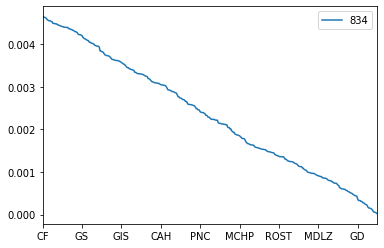

In [106]:
random_allocation_df[random_allocation_df["all Vols"] == all_vol.min()].transpose().drop(["Sharps",
                        "all Vols", "all_returns"]).sort_values(834, ascending = False).plot()

In [112]:
random_allocation_df[random_allocation_df["all_returns"] == all_returns.max()].transpose().drop(["Sharps",
                        "all Vols", "all_returns"]).sort_values(213, ascending = False).head(20)

,213
KMB,0.004611
HRL,0.004606
RF,0.004590
WDC,0.004585
MSI,0.004579
DRE,0.004574
AMD,0.004574
KO,0.004556
NFLX,0.004535
NTAP,0.004523


In [113]:
random_allocation_df

,Sharps,all Vols,all_returns,MMM,AOS,ABT,ACN,ATVI,AYI,ADBE,...,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,YUM,ZBH,ZION
0,0.795924,0.188594,0.150107,0.003477,0.001425,2.868633e-07,0.001667,0.001057,0.003193,0.003028,...,0.000345,0.003904,0.004026,0.000205,0.000783,0.000585,0.003815,0.001741,0.002437,0.004652
1,0.786016,0.187959,0.147739,0.003414,0.004202,4.261506e-03,0.004137,0.000526,0.001657,0.003958,...,0.002735,0.002721,0.000670,0.000344,0.003898,0.000385,0.001820,0.001140,0.003534,0.002187
2,0.784577,0.188108,0.147585,0.000902,0.004115,1.382467e-03,0.001075,0.002607,0.000288,0.003656,...,0.004532,0.002947,0.003176,0.000047,0.002609,0.000233,0.001821,0.000744,0.001036,0.001396
3,0.805457,0.186523,0.150237,0.002971,0.002829,1.822727e-03,0.001705,0.002172,0.000558,0.000052,...,0.003195,0.002898,0.004006,0.001271,0.000815,0.002880,0.000622,0.000247,0.003610,0.000597
4,0.788990,0.189476,0.149495,0.000511,0.004532,3.125251e-03,0.002973,0.003099,0.002088,0.001960,...,0.004215,0.001742,0.002014,0.003458,0.001567,0.000876,0.000689,0.003855,0.000590,0.001180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.793747,0.188954,0.149982,0.001578,0.000927,1.280502e-03,0.004624,0.001591,0.003100,0.000182,...,0.002763,0.000430,0.000245,0.003022,0.001231,0.003832,0.003940,0.003982,0.001947,0.002831
1996,0.806006,0.187626,0.151228,0.002494,0.003775,3.563485e-03,0.001862,0.001500,0.004278,0.001145,...,0.002095,0.004431,0.002957,0.001058,0.001391,0.002448,0.002332,0.001074,0.004308,0.001839
1997,0.778071,0.189697,0.147598,0.003656,0.001029,2.828402e-03,0.000266,0.000352,0.003971,0.001929,...,0.002969,0.001706,0.003899,0.001368,0.000532,0.003578,0.003802,0.001227,0.002427,0.003022
1998,0.785410,0.190312,0.149473,0.004029,0.004375,2.828057e-03,0.002234,0.002285,0.004558,0.002057,...,0.002308,0.004592,0.001511,0.002613,0.001070,0.002935,0.002370,0.003747,0.002185,0.000599
